In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [22]:
filenames = glob.glob("data/lsb.*.r*") + glob.glob("data/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [23]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]

In [24]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput
id,,,,,,,,,
0,parallel sollin EL,10000,Erdos-Renyi random,1,0,939626.318359,1,"(Erdos-Renyi random, 10000)",0.000001
0,parallel sollin EL,10000,Erdos-Renyi random,1,1,918234.640137,2,"(Erdos-Renyi random, 10000)",0.000001
0,parallel sollin EL,10000,Erdos-Renyi random,1,2,899298.442383,1,"(Erdos-Renyi random, 10000)",0.000001
0,parallel sollin EL,10000,Erdos-Renyi random,2,0,730224.237793,0,"(Erdos-Renyi random, 10000)",0.000001
0,parallel sollin EL,10000,Erdos-Renyi random,2,1,722391.649902,0,"(Erdos-Renyi random, 10000)",0.000001


In [25]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead,Graph,Throughput
id,,,,,,,,,
0,Filter Kruskal,100000,Erdos-Renyi random,16,1,88482.005859,0,"(Erdos-Renyi random, 100000)",0.000011
0,Filter Kruskal,100000,Erdos-Renyi random,16,2,90793.824951,0,"(Erdos-Renyi random, 100000)",0.000011
0,Filter Kruskal,100000,Erdos-Renyi random,32,0,112364.854248,0,"(Erdos-Renyi random, 100000)",0.000009
0,Filter Kruskal,100000,Erdos-Renyi random,32,1,127591.381592,15,"(Erdos-Renyi random, 100000)",0.000008
0,Filter Kruskal,100000,Erdos-Renyi random,32,2,135814.080322,0,"(Erdos-Renyi random, 100000)",0.000007


In [26]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [27]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [28]:
summary

time                \
                                                  median          mean   
Algorithm          Max threads Graph nodes                               
Boost Kruskal      1           1000         5.840215e+03  6.094821e+03   
                               10000        1.272224e+05  1.870765e+05   
                               100000       2.915058e+06  3.922875e+06   
                               1524453      7.810995e+06  7.805934e+06   
                   2           1000         5.253658e+03  5.256799e+03   
                               10000        1.272574e+05  1.826181e+05   
                               100000       2.774134e+06  3.771850e+06   
                               1524453      8.169554e+06  8.143045e+06   
                   4           1000         5.220374e+03  5.264223e+03   
                               10000        1.277210e+05  1.871724e+05   
                               100000       2.729078e+06  3.731836e+06   
                               1524453      8.231641e+06  8.244669e+06   
                   8           1000         5.290210e+03  5.272127e+03   
                               10000        1.271689e+05  1.842636e+05   
                               100000       2.744675e+06  3.743096e+06   
                               1524453      8.083295e+06  8.128877e+06   
                   16          1000         5.254519e+03  5.281181e+03   
                               10000        1.272805e+05  1.837728e+05   
                               100000       2.719921e+06  3.760345e+06   
                               1524453      8.759788e+06  8.689718e+06   
                   32          1000         5.281173e+03  5.295179e+03   
                               10000        1.277111e+05  1.841670e+05   
                               100000       2.733118e+06  3.749674e+06   
                               1524453      8.995894e+06  8.807345e+06   
Filter Kruskal     1           1000         1.262547e+03  1.326859e+03   
                               10000        1.789052e+04  2.211196e+04   
                               100000       3.480727e+05  3.376098e+05   
                               1524453      2.236985e+06  2.034741e+06   
                   2           1000         1.616514e+03  1.583898e+03   
                               10000        1.724544e+04  2.024637e+04   
...                                                  ...           ...   
parallel sollin EL 2           1000         4.524493e+04  4.631834e+04   
                               10000        7.248908e+05  7.801077e+05   
                               100000       1.918776e+07  4.354821e+07   
                               264346       1.486369e+06  4.711380e+06   
                               321270       1.661834e+06  1.661834e+06   
                               435666       2.536018e+06  7.967475e+06   
                   4           1000         5.412358e+04  5.626105e+04   
                               10000        9.927817e+05  1.071335e+06   
                               100000       2.136401e+07  3.300543e+07   
                               264346       2.017332e+06  2.242119e+06   
                               321270       2.370536e+06  2.370536e+06   
                               435666       3.018384e+06  3.027246e+06   
                   8           1000         8.682156e+04  8.552097e+04   
                               10000        1.504824e+06  1.519381e+06   
                               100000       2.603926e+07  3.003954e+07   
                               264346       2.597350e+06  2.844751e+06   
                               321270       2.892868e+06  2.892868e+06   
                               435666       3.753257e+06  4.488339e+06   
                   16          1000         1.196935e+05  1.186032e+05   
                               10000        1.896507e+06  1.978739e+06   
                               100000       3.075290e+07

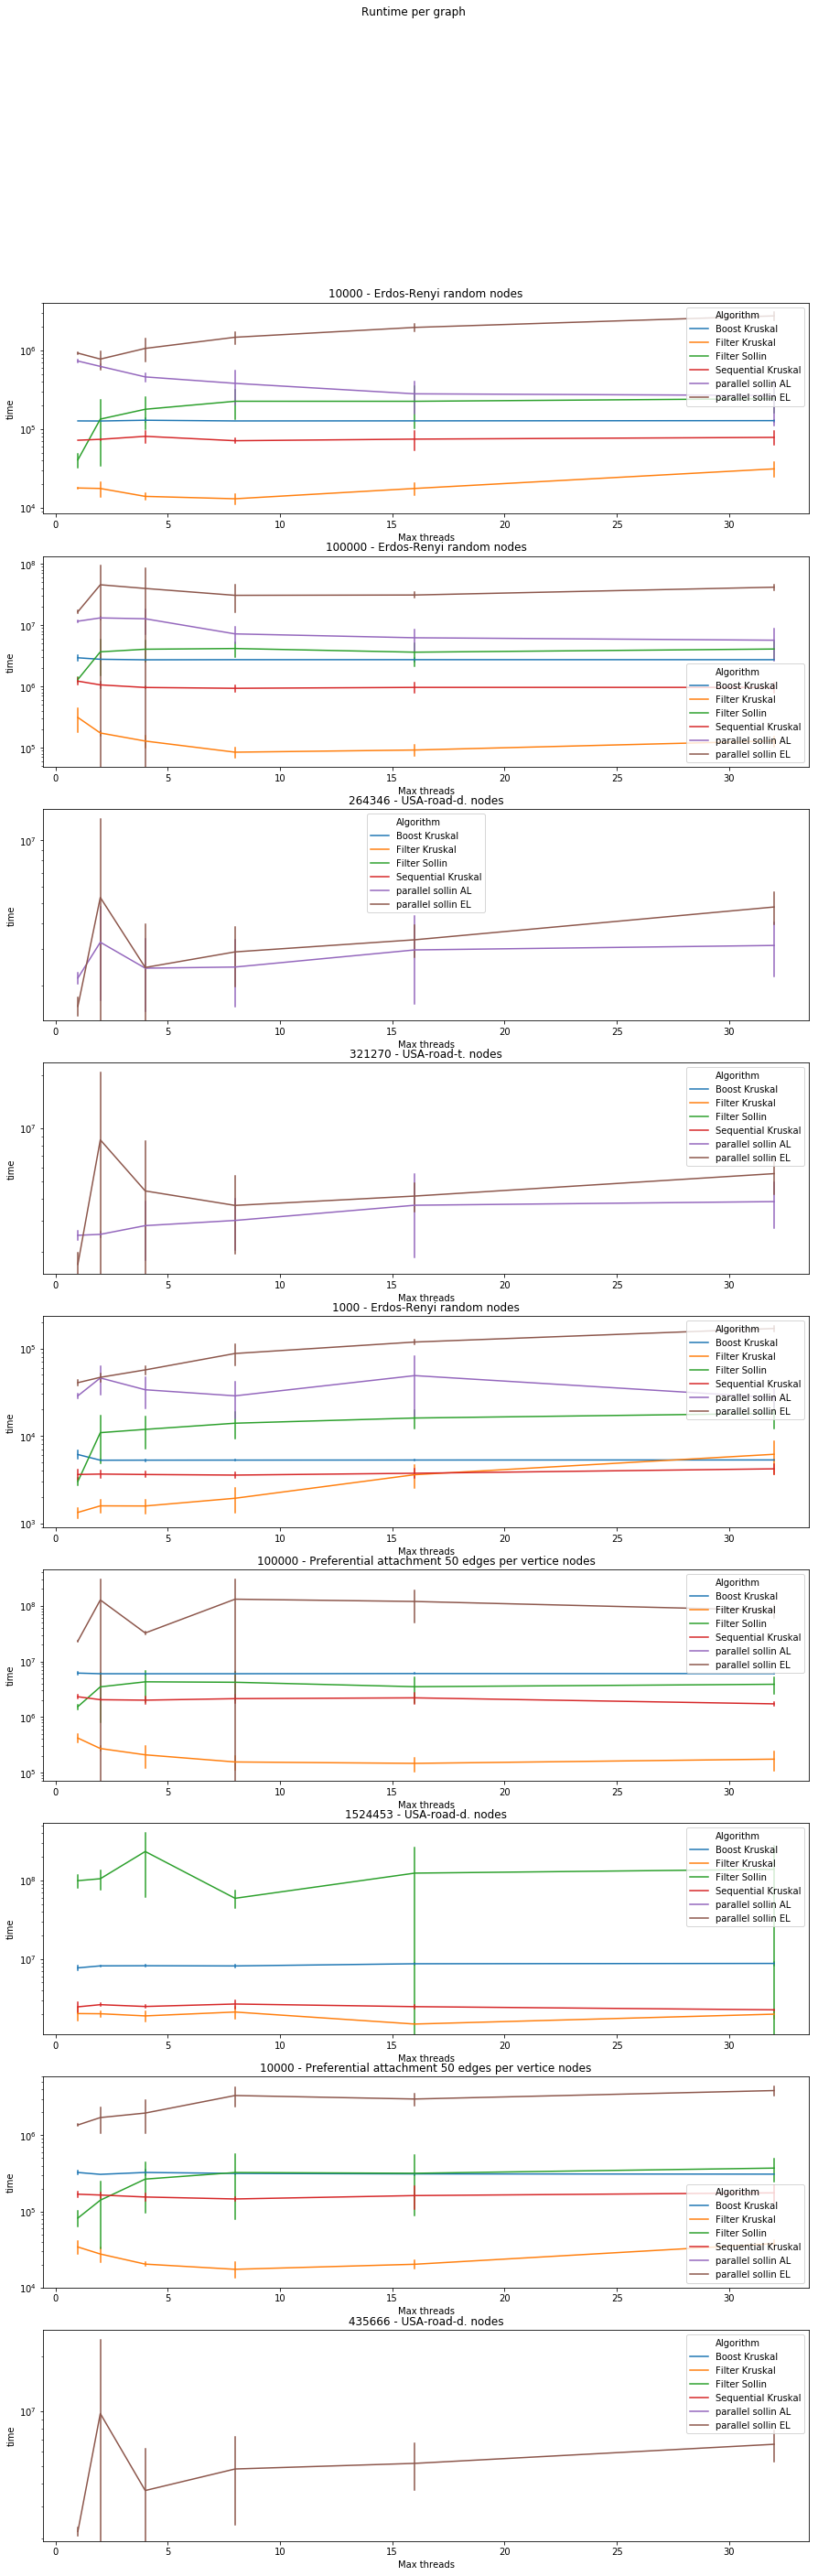

In [29]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")
    #ax[i].set_ylim(1,)
plt.suptitle("Runtime per graph")
plt.show()

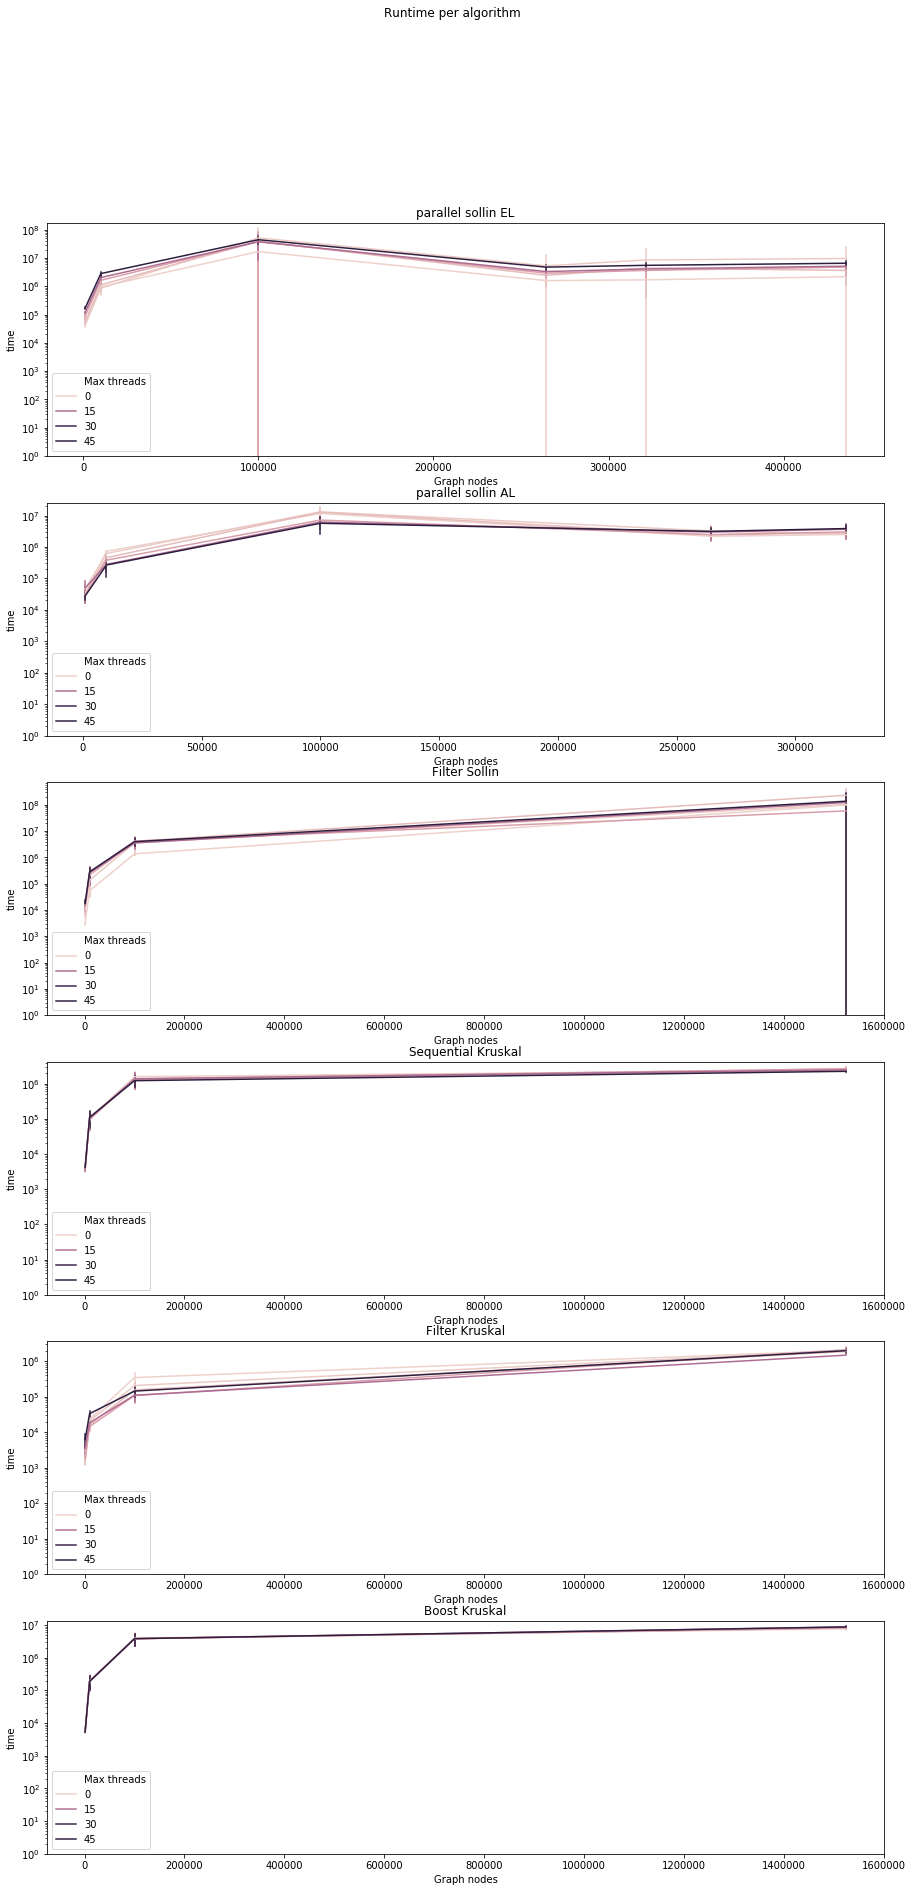

In [30]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e}")
    ax[i].set_ylim(1,)
plt.suptitle("Runtime per algorithm")
plt.show()

In [31]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


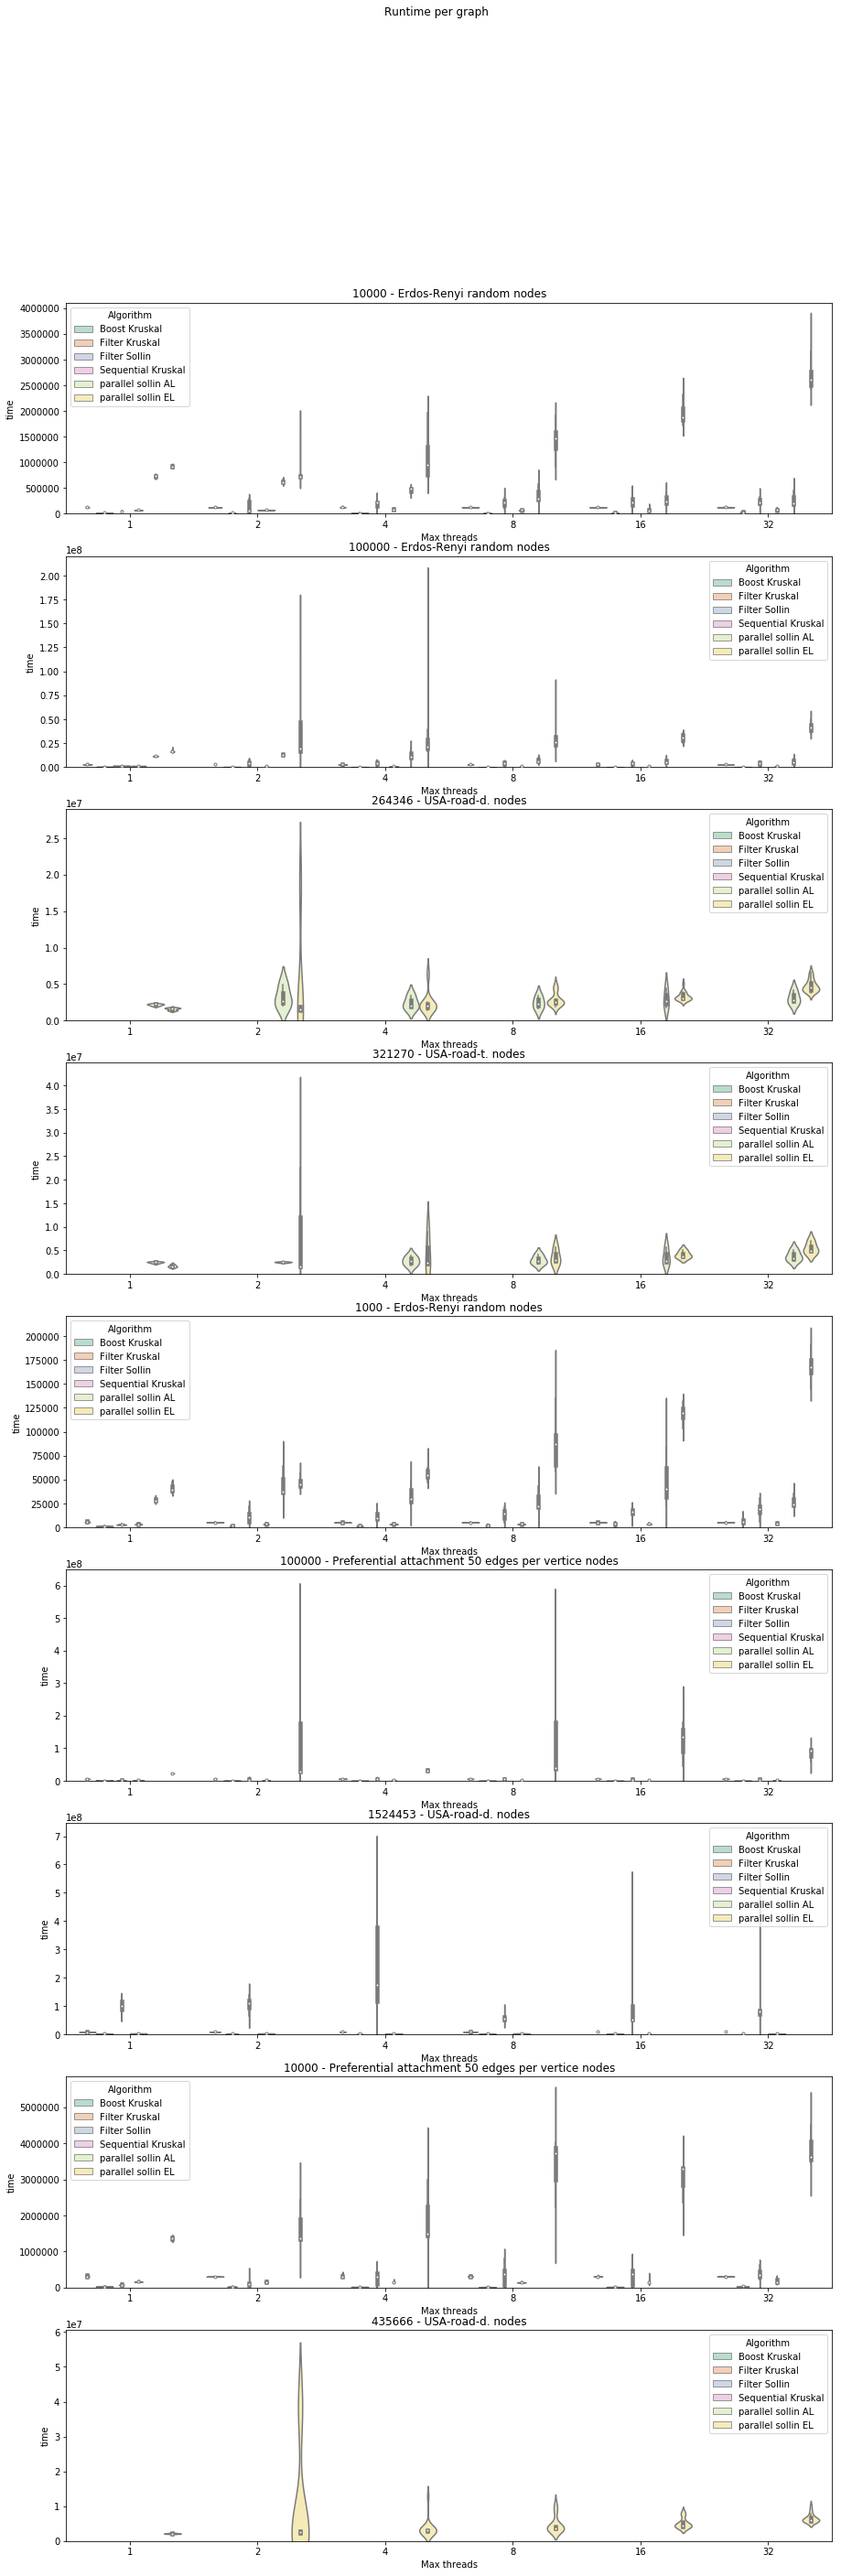

In [32]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
plt.show()

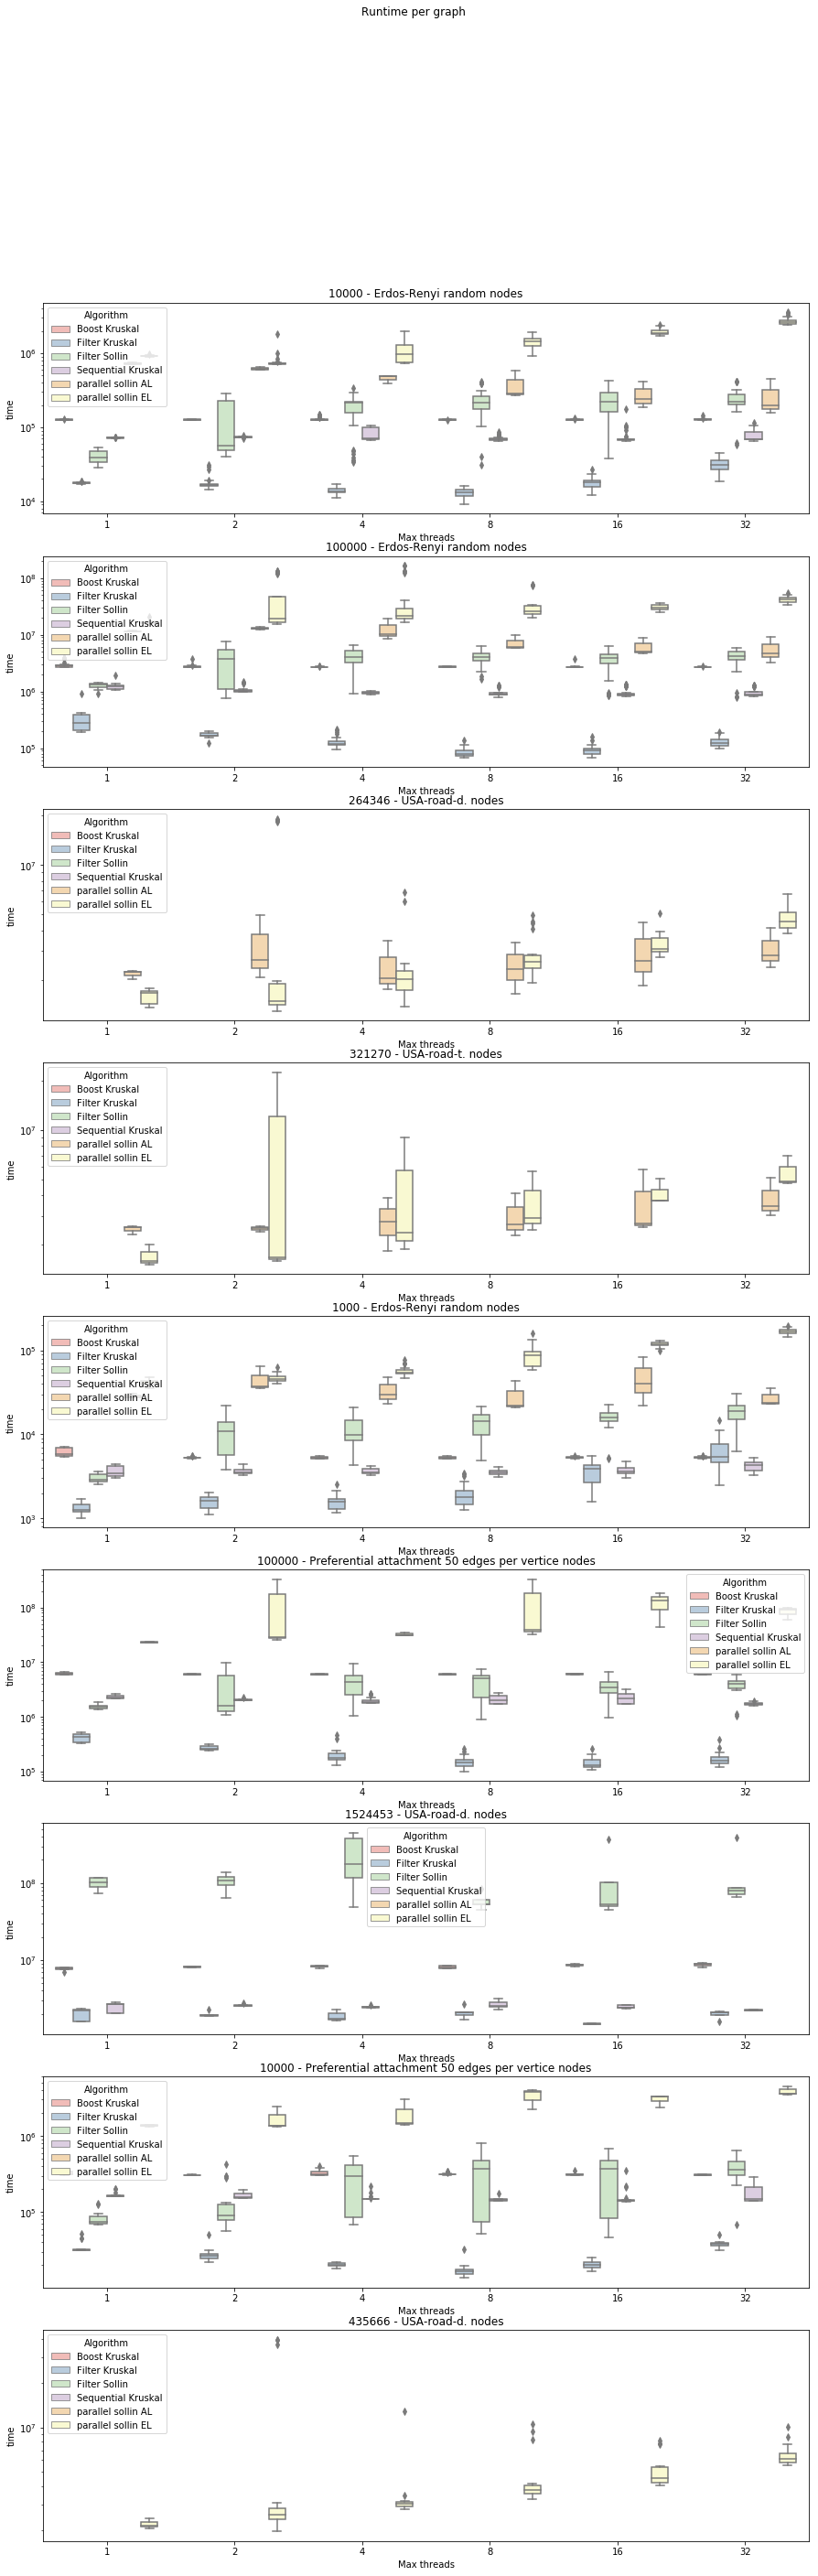

In [33]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")
plt.suptitle("Runtime per graph")
plt.show()

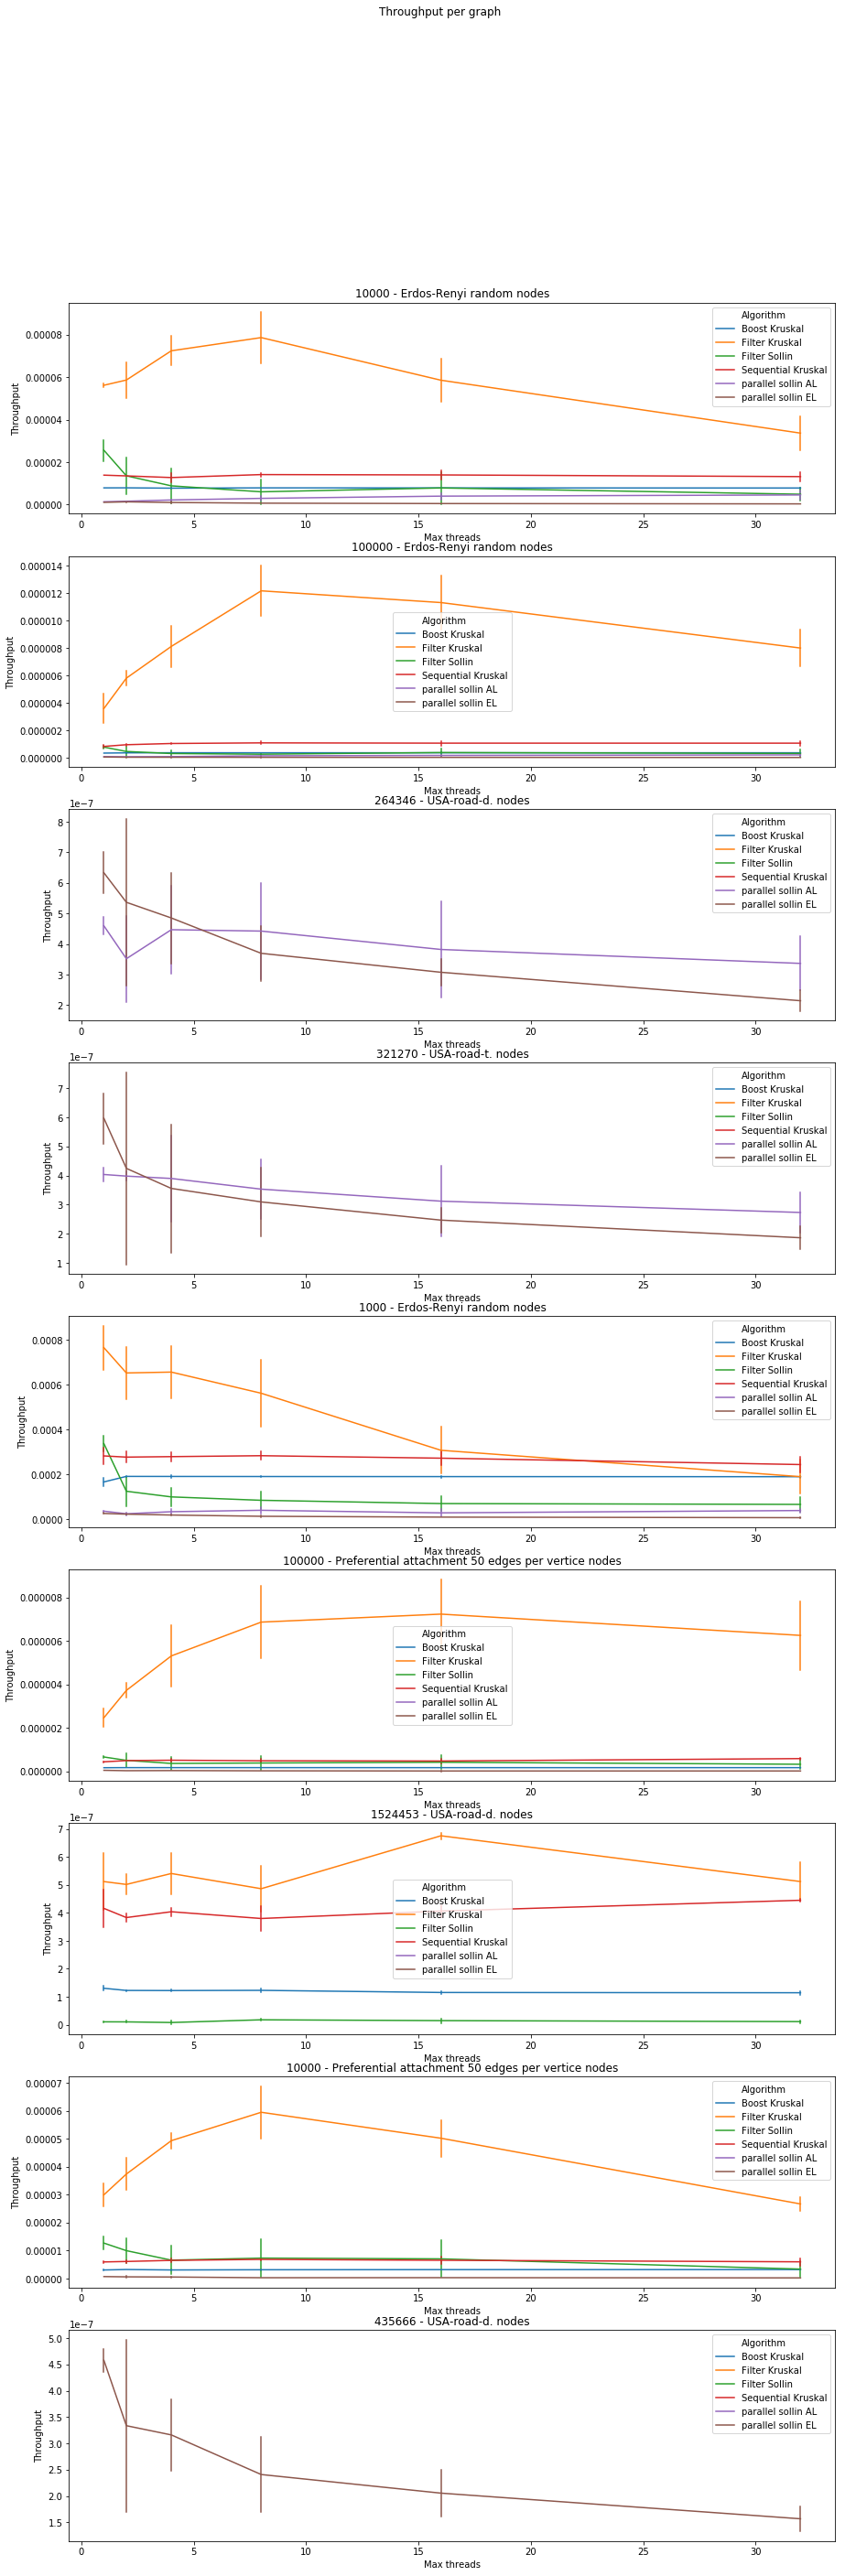

In [38]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")
    #ax[i].set_ylim(1,)
plt.suptitle("Throughput per graph")
plt.show()

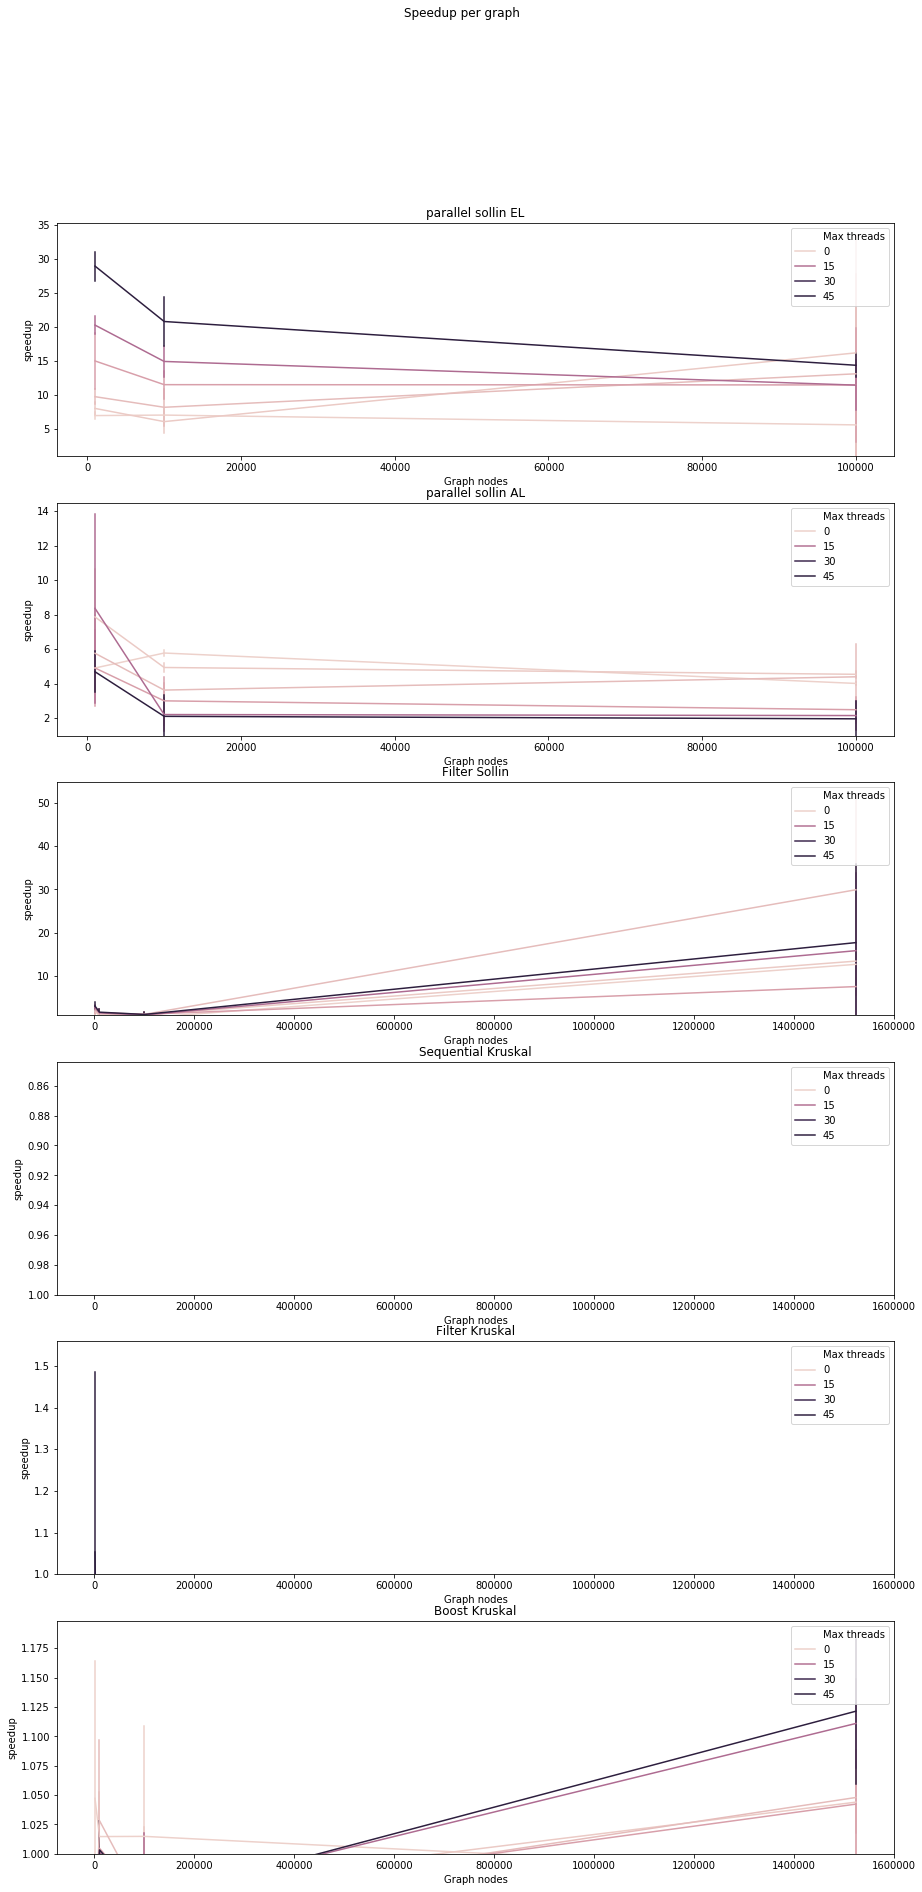

In [50]:
reference_algorithm = "Boost Kruskal"
reference_times = df[(df.Algorithm == reference_algorithm) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']

df['speedup'] = df.apply(lambda x: x.time / reference_times[x.Graph] if x.Graph in reference_times.index else None , 1)

fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="speedup", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e}")
    ax[i].set_ylim(1,)
plt.suptitle("Speedup per graph")
plt.show()